In [1]:
from typing import List, Tuple, Optional

import os
import logging
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm import tqdm

from master_thesis.utils import LOGLEVEL_MAP
from master_thesis.classification_models import *
from master_thesis.tools.data import  load_np_data, Preprocessing
from master_thesis.tools.plots import plot_sample_networks, plot_weight_histogram

logging.basicConfig(level=LOGLEVEL_MAP["INFO"])

SEED = 42
K_FOLDS = 10

# === Scale Free Synthetic Dataset ===
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeBias/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeEasy/networks"

# === Real World Stroke Split Dataset ===
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksFC/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksGC/networks"
NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksRCC/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksUnidirRCC/networks"

# Load dataset

In [20]:
X, y = Preprocessing(
    undirected=False,
    connection_weight_threshold=(0.6, -0.6),
    subtract_control_mean=True)(*load_np_data(
    NETWORKS_DIR_PATH,
    channel=0
))
print(len(X), len(y))

449 449


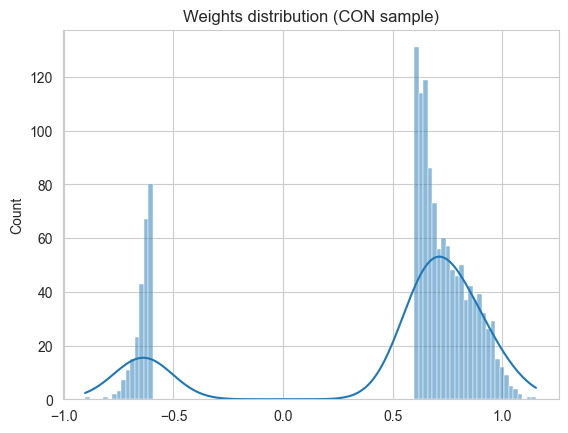

Ratio of edges to the full graph: 0.2795959595959596


In [21]:
idx = 5
plot_weight_histogram(X[idx], y[idx])
print(f"Ratio of edges to the full graph: {len(X[idx].edges) / (50 * 99)}")

### Plot sample class members

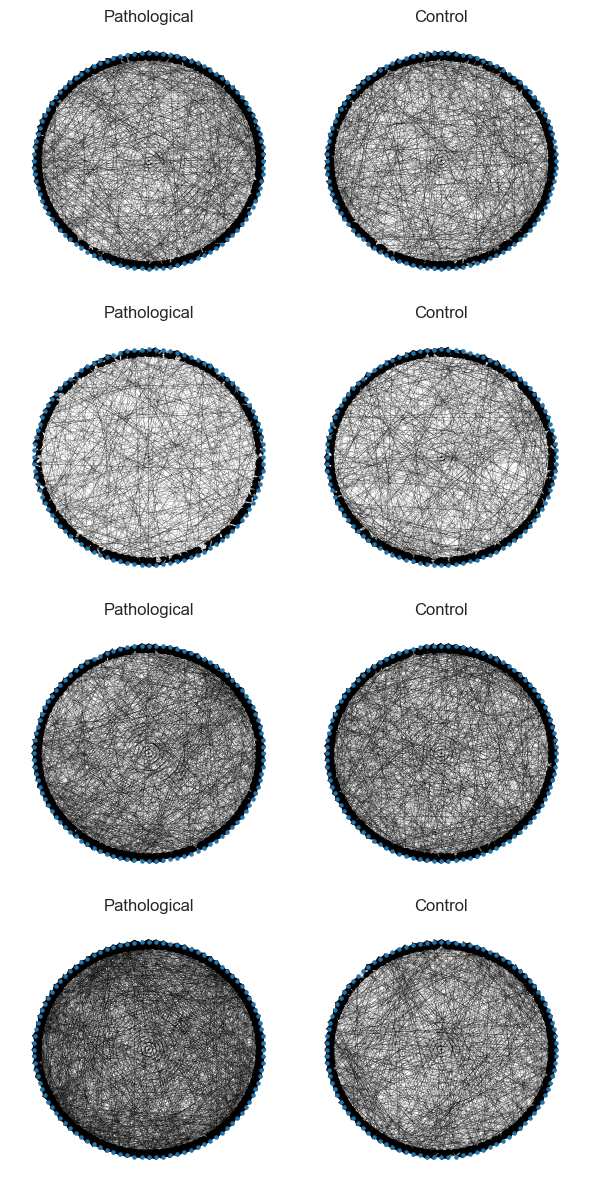

In [22]:
# Plot sample networks
plot_sample_networks(X, y, rows=4)

## Embedd networks (optionally)

In [23]:
# graph2vec = Graph2Vec(dimensions=32, wl_iterations=2, epochs=200, seed=SEED, workers=1)
# graph2vec.fit(X)
# X = graph2vec.get_embedding()

# Pipe through the LDP model

## Leave-one-out cross-validation

In [ ]:
# Define accumulator lists
y_gold_train_acc, y_hat_train_acc = [], []
y_gold_test_acc, y_hat_test_acc = [], []

# Define k-fold cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in tqdm(enumerate(kfold.split(X)), total=K_FOLDS, desc="Cross-validation"):

    # Split data
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train model (Graph2Vec)
    # model = VectorModel()
    # model.fit(X_train, y_train)

    # Train model (LTP)
    model = LTPModel(log_degree=True)
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict(X_train)
    y_hat_train_acc.append(y_hat_train)
    y_gold_train_acc.append(y_train)

    y_hat_test = model.predict(X_test)
    y_hat_test_acc.append(y_hat_test)
    y_gold_test_acc.append(y_test)

# Concatenate lists
y_hat_train = np.concatenate(y_hat_train_acc)
y_gold_train = np.concatenate(y_gold_train_acc)

y_hat_test = np.concatenate(y_hat_test_acc)
y_gold_test = np.concatenate(y_gold_test_acc)

In [ ]:
# Evaluate classification
print("=== Evaluating model on train data ===")
print(BaseModel.evaluate(y_gold_train, y_hat_train, save_path="ltp_cm_train.png"))

print("=== Evaluating model on test data ====")
print(BaseModel.evaluate(y_gold_test, y_hat_test, save_path="ltp_cm_test.png"))

## Holdout

In [25]:
# import warnings
# warnings.filterwarnings('ignore')

holdout_size = 0.2
holdout_size = int(holdout_size * len(X))

# Shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X = [X[i] for i in idx]
y = [y[i] for i in idx]

# Split data
X_train, X_test = X[:-holdout_size], X[-holdout_size:]
y_train, y_test = y[:-holdout_size], y[-holdout_size:]

# Train model
model = GCNModel(learning_rate=0.005, epochs=100, print_every=20, ldp_features=True)
model.fit(X_train, y_train)

======= Epoch: 020 =======
    Train loss: 0.0120
Accuracy:  0.84
Recall:    1.00
Precision: 0.84
f1 score:  0.91
AUC score: 0.50

    Validation loss: 0.0193
Accuracy:  0.85
Recall:    1.00
Precision: 0.85
f1 score:  0.92
AUC score: 0.50


======= Epoch: 040 =======
    Train loss: 0.0120
Accuracy:  0.19
Recall:    0.03
Precision: 1.00
f1 score:  0.06
AUC score: 0.51

    Validation loss: 0.0192
Accuracy:  0.19
Recall:    0.05
Precision: 1.00
f1 score:  0.09
AUC score: 0.52




/Users/wciezobka/venvs/sano/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= Epoch: 060 =======
    Train loss: 0.0118
Accuracy:  0.82
Recall:    0.91
Precision: 0.88
f1 score:  0.89
AUC score: 0.64

    Validation loss: 0.0192
Accuracy:  0.83
Recall:    0.92
Precision: 0.89
f1 score:  0.90
AUC score: 0.64


======= Epoch: 080 =======
    Train loss: 0.0118
Accuracy:  0.23
Recall:    0.08
Precision: 0.95
f1 score:  0.15
AUC score: 0.53

    Validation loss: 0.0195
Accuracy:  0.21
Recall:    0.08
Precision: 0.83
f1 score:  0.15
AUC score: 0.50


======= Epoch: 100 =======
    Train loss: 0.0116
Accuracy:  0.68
Recall:    0.70
Precision: 0.89
f1 score:  0.79
AUC score: 0.64

    Validation loss: 0.0181
Accuracy:  0.68
Recall:    0.70
Precision: 0.90
f1 score:  0.79
AUC score: 0.63




<Figure size 640x480 with 0 Axes>

In [26]:
print("=== Evaluating model on train data ===")
y_hat_train = model.predict(X_train)
print(BaseModel.evaluate(np.array(y_train), y_hat_train, save_path="gcn_cm_train.png"))

print("=== Evaluating model on test data ====")
y_hat_test = model.predict(X_test)
print(BaseModel.evaluate(y_test, y_hat_test, save_path="gcn_cm_test.png"))

INFO:root:Loaded model from epoch 92 with validation metric 0.6908


=== Evaluating model on train data ===


INFO:root:Loaded model from epoch 92 with validation metric 0.6908


Accuracy:  0.76
Recall:    0.81
Precision: 0.89
f1 score:  0.85
AUC score: 0.66

=== Evaluating model on test data ====
Accuracy:  0.73
Recall:    0.77
Precision: 0.91
f1 score:  0.83
AUC score: 0.61



<Figure size 640x480 with 0 Axes>